In [4]:
#|default_exp core_beta
## Standard libraries
import os
import math
import numpy as np
import time
from nbdev.showdoc import *
# Configure environment
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE']='false' # Tells Jax not to hog all of the memory to this process.

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
# set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgba
import seaborn as sns
sns.set()

## Progress bar
from tqdm.auto import tqdm

## project specifics
import diffusion_curvature
from diffusion_curvature.kernels import *
from diffusion_curvature.datasets import *
from diffusion_curvature.utils import *
import jax
import jax.numpy as jnp
jax.devices()

%load_ext autoreload
%autoreload 2

# Implementation (PyGSP + JAX)
> Curvature computations on any graphtools graph

This notebook implements diffusion curvature atop the popular PyGSP library. To compute the curvature of any PyGSP graph, simply instantiate a `DiffusionCurvature` object with your choice of parameters, and pass the PyGSP graph through as input.

What follows is a literate implementation, showing the steps of the algorithm applied to our old friend, the torus.

The implementation of Diffusion Curvature involves several big pieces, each of which can be performed with different strategies:

1. Simulating heat diffusion on the manifold, either via powering the diffusion matrix, or by Chebyshev approximation of the heat equation using the graph laplacian.
2. Computing the "spreads" of diffusion. This can be done either via the entropy or the Wasserstein distance.
3. Constructing a comparison space of approximately the same sampling as the input graph.
4. (Experimental) Verification that the above is working by differentiating the spreads of diffusion over time.

We implement everything generically in JAX (a high performance numpy replacement, which can compile to the GPU), treating each of the above as modules that can be parametrically tuned. Functional programming is our game: each function takes a graph object as input and returns an updated graph object with the required quantities computed. 

In [5]:
from diffusion_curvature.datasets import torus

In [7]:
# Our sample dataset for testing the rest of the notebook
X_torus, ks_torus = torus(2000,use_guide_points=False)

# Graph Construction
Our 'Graphs' notebook has code to create PyGSP graphs from pointcloud data, in several varieties. 
We also provide heuristics to sanity check the graphs, as well as choose the optimal parameters.
TODO: MAKE THESE HEURISTICS

# The Diffusion Curvature Class

In [26]:
#|export
import pygsp
import jax
import jax.numpy as jnp
import numpy as np
from fastcore.all import *
import skdim
import scipy
from sklearn.preprocessing import normalize

from inspect import getfullargspec
from typing import Callable, Literal, get_args, get_origin
import graphtools
from tqdm.auto import trange, tqdm

from jax.experimental import sparse

# Graph operations, laziness, measures
from diffusion_curvature.graphs import diff_aff, diff_op, diffusion_matrix_from_affinities
from diffusion_curvature.heat_diffusion import heat_diffusion_on_signal, kronecker_delta, jax_power_matrix, heat_diffusion_from_dirac
from diffusion_curvature.diffusion_laziness import wasserstein_spread_of_diffusion, entropy_of_diffusion
from diffusion_curvature.distances import phate_distances
from diffusion_curvature.datasets import plane

# Comparison space construction
from diffusion_curvature.comparison_space import PointCloudFlattener, EuclideanComparisonSpace, fit_comparison_space_model, euclidean_comparison_graph, construct_ndgrid_from_shape, diffusion_coordinates, load_average_entropies
# from diffusion_curvature.normalizing_flows import neural_flattener
# from diffusion_curvature.flattening.mioflow_quicktrain import MIOFlowStandard

# Algorithmic niceties
from diffusion_curvature.clustering import enhanced_spectral_clustering
from diffusion_curvature.vne import optimal_t_via_vne
from diffusion_curvature.utils import random_jnparray

import diffusion_curvature

import torch

# import deepdish
import h5py

def graphtools_graph_from_data(X):
    return graphtools.Graph(X, anisotropy=1, knn=15, decay=None).to_pygsp()

from diffusion_curvature.kernels import gaussian_kernel
from dataclasses import dataclass

@dataclass
class SimpleGraph:
    W: np.ndarray

def get_adaptive_graph(X, k = 5, alpha = 1):
    W = gaussian_kernel(
        X,
        kernel_type='adaptive',
        k = k,
        anisotropic_density_normalization = alpha,
    )
    G = pygsp.graphs.Graph(W)
    return G

def get_fixed_graph(X, sigma, alpha):
    W = gaussian_kernel(
        X, 
        kernel_type = "fixed",
        sigma = sigma,
        anisotropic_density_normalization = alpha,
    )
    # set diagonal of W to zero
    np.fill_diagonal(W, 0)
    G = pygsp.graphs.Graph(W)
    return G

default_fixed_graph_former = partial(get_fixed_graph, sigma = 0.2, alpha = 1)

_DIFFUSION_TYPES = Literal['diffusion matrix','heat kernel']
_LAZINESS_METHOD = Literal['Wasserstein','Entropic', 'Laziness', 'Wasserstein Normalized']
_FLATTENING_METHOD = Literal['Neural', 'Fixed', 'Mean Fixed', 'MIOFlow', 'Radial Flattener']
_COMPARISON_METHOD = Literal['Ollivier', 'Subtraction']

class DiffusionCurvature():
    def __init__(
            self,
            diffusion_type:_DIFFUSION_TYPES = 'diffusion matrix', # Either ['diffusion matrix','heat kernel']
            laziness_method: _LAZINESS_METHOD = 'Entropic', # Either ['Wasserstein','Entropic', 'Laziness']
            flattening_method: _FLATTENING_METHOD = 'Scaled Fixed', # Either ['Neural', 'Fixed', 'Mean Fixed', 'MIOFlow']
            comparison_method: _COMPARISON_METHOD = 'Subtraction', # Either ['Ollivier', 'Subtraction']
            graph_former = default_fixed_graph_former,
            dimest = None, # Dimension estimator to use. If none, defaults to kNN.
            points_per_cluster = None, # Number of points to use in each cluster when constructing comparison spaces. Each comparison space takes about 20sec to construct, and has different sampling and dimension. If 1, constructs a different comparison space for each point; if None, constructs just one comparison space.
            comparison_space_size_factor = 1, # Number of points in comparison space is the number of points in the original space divided by this factor.
            use_grid=False, # If True, uses a grid of points as the comparison space. If False, uses a random sample of points.            
            max_flattening_epochs=50,     
            aperture = 20, # if using Laziness flattening, this controls the size of neighborhood over which the return probability is averaged.
            smoothing=1,
            distance_t = None,
            comparison_space_file = "../data/entropies_averaged.h5",
            verbose = False,
            scale_euclidean_space = True,
    ):
        store_attr()
        self.D = None
        self.laziness = None
        self.graph_former = graph_former
        if self.dimest is None:
            self.dimest = skdim.id.KNN()
        if self.flattening_method == "Mean Fixed":
            self.SGT = load_average_entropies(comparison_space_file)
            # deepdish.io.load("../data/sgt_peppers_averaged_flat_entropies.h5") # dict of dim x knn x ts containing precomputed flat entropies.
        
        self.flattener = PointCloudFlattener(flattening_method=self.flattening_method, graph_former = self.graph_former, diffusion_curvature_instance=self)

        
    def unsigned_curvature(
            self,
            G:pygsp.graphs.Graph, # PyGSP input Graph
            t:int, # Scale at which to compute curvature; number of steps of diffusion.
            idx=None, # the index at which to compute curvature. If None, computes for all points. TODO: Implement
            # The below are used internally
            _also_return_first_scale = False, # if True, calculates the laziness measure at both specified t and t=1. The distances (if used) are calcualted with the larger t.
            D = None, # Supply manifold distances yourself to override their computation. Only used with the Wasserstein laziness method.
            
    ):
        n = G.W.shape[0]
        # Compute diffusion matrix
        match self.diffusion_type:
            case 'diffusion matrix':
                # if W has no self loops, i.e. zeros on the diagonal, then we must add ones to the diagonal
                # if np.all(G.W.diagonal() == 0):
                #     G.W.setdiag(1)
                P = normalize(G.W, norm="l1", axis=1)
                if type(P) == scipy.sparse._csr.csr_matrix:
                    P = P.todense()
                # diffusion_matrix_from_affinities(G.W)
                # P = diff_op(G).todense() # is sparse, by default
                self.P = jnp.array(P)
                if t is None: t = optimal_t_via_vne(P)
                self.Pt = jax_power_matrix(self.P,t)
                if self.distance_t is not None:
                    self.P_dist = jax_power_matrix(self.P,self.distance_t)
                else:
                    self.P_dist = jax_power_matrix(self.P, t)
            case 'heat kernel':
                if self.distance_t is None:
                    self.distance_t = t
                if t is None: 
                    normal_P = normalize(G.W, norm="l1", axis=1)
                    if type(normal_P) == scipy.sparse._csr.csr_matrix:
                        normal_P = normal_P.todense()
                    normal_P = jnp.array(normal_P)
                    t = optimal_t_via_vne(normal_P)
                Ps = heat_diffusion_from_dirac(G, idx=idx, t=[1,self.distance_t, t])
                # signal = jnp.eye(n) if idx is not None else kronecker_delta(n,idx=idx)
                # Ps = heat_diffusion_on_signal(G, signal, [1,t])
                self.P = Ps[0]
                self.P_dist = Ps[1]
                self.Pt = Ps[2]
            case _:
                raise ValueError(f"Diffusion Type {self.diffusion_type} not in {_DIFFUSION_TYPES}")
        self.t = t
        match self.laziness_method:
            case "Wasserstein":
                if D is None: 
                    # raise NotImplementedError("If using Wasserstein-style diffusion curvature, you must pass in precomputed manifold distances with the 'D = ' parameter. If you don't want to compute those, we recommend setting the laziness type to 'Entropic'")
                    D = phate_distances(self.P_dist) #TODO: Could be more efficient here if there's an idx
                self.D = D
                laziness = wasserstein_spread_of_diffusion(D,self.Pt) if idx is None else wasserstein_spread_of_diffusion(D[idx],self.Pt[idx])
                if _also_return_first_scale: laziness_nought = wasserstein_spread_of_diffusion(D,self.P)
            case "Wasserstein Normalized":
                if D is None: 
                    if self.distance_t is not None:
                        self.P_dist = jax_power_matrix(self.P,self.distance_t)
                    else:
                        self.P_dist = jax_power_matrix(self.P, t)
                    # raise NotImplementedError("If using Wasserstein-style diffusion curvature, you must pass in precomputed manifold distances with the 'D = ' parameter. If you don't want to compute those, we recommend setting the laziness type to 'Entropic'")
                    D = phate_distances(self.P_dist) #TODO: Could be more efficient here if there's an idx
                laziness = wasserstein_spread_of_diffusion(D,self.Pt) if idx is None else wasserstein_spread_of_diffusion(D[idx],self.Pt[idx])
                laziness_nought = wasserstein_spread_of_diffusion(D,self.P) if idx is None else wasserstein_spread_of_diffusion(D[idx],self.P[idx])
                laziness = laziness / (laziness_nought @ jax_power_matrix(self.P, self.smoothing))
            case "Entropic":
                laziness = entropy_of_diffusion(self.Pt) if idx is None else entropy_of_diffusion(self.Pt[idx])
                # laziness = entropy_of_diffusion(self.P) / entropy_of_diffusion(self.Pt)
                if _also_return_first_scale: laziness_nought = entropy_of_diffusion(self.P)
            case "Laziness":
                thresholds = jnp.partition(self.P,-self.aperture)[:,-self.aperture] # aperture controls the size of the neighborhood in which laziness is measured
                P_thresholded = (self.P >= thresholds[:,None]).astype(int) 
                near_neighbors_only = self.Pt * P_thresholded
                laziness_aggregate = jnp.sum(near_neighbors_only,axis=1)
                # divide by the number of neighbors diffused to
                ones_remaining = jnp.ones_like(P_thresholded) * P_thresholded # is this needed? Isn't ones_remaining identical to P_thresholded?
                local_density = jnp.sum(ones_remaining,axis=1)
                if self.verbose: print("local density",local_density)
                local_density = local_density.at[local_density==0].set(1) # In case of isolated points, replace local density of 0 with 1. THe laziness will evaluate to zero.
                laziness_aggregate = laziness_aggregate / local_density 
                laziness = laziness_aggregate
                if self.smoothing: # TODO there are probably more intelligent ways to do this smoothing
                    # Local averaging to counter the effects local density
                    if self.verbose: print("Applying smoothing...")
                    smoothing_P_powered = jnp.linalg.matrix_power(self.P,self.smoothing)
                    average_laziness = smoothing_P_powered @ laziness_aggregate[:,None]
                    laziness = average_laziness.squeeze()
                    
                if _also_return_first_scale: laziness_nought = jnp.sum(self.P * P_thresholded,axis=1)
            case _:
                raise ValueError(f"Laziness Method {self.laziness_method} not in {_LAZINESS_METHOD}")
        self.laziness = laziness
        if _also_return_first_scale: 
            return laziness, laziness_nought, self.P, self.Pt, t
        else:
            return laziness

    def spectral_transform(self, G, signal):
        A = jnp.array(G_torus.W.todense())
        e, v = jnp.linalg.eigh(A)
        loadings = v.T
        transformed_signal = loadings @ signal
        return transformed_signal, e

    def fit(
            self,
            G:pygsp.graphs.Graph, # Input Graph
            dim = None, # the INTRINSIC dimension of your manifold, as an int for global dimension or list of pointwise dimensions; if none, tries to estimate pointwise.
            t:int = None, # Scale; if none, finds the knee-point of the spectral entropy curve of the diffusion operator
            idx=None, # the index at which to compute curvature. If None, computes for all points.
            unsigned = False, # If True, computes unsigned curvature. If False, computes signed curvature.
            D = None, # Supply manifold distances yourself to override their computation. Only used with the Wasserstein laziness method.
            X = None, # if using a flattening method that requires a point cloud, supply it here.
            knn = 15,
    ):
        self.G = G
        self.X = X
        self.D = D
        self.unsigned_ks = self.unsigned_curvature(G = G, t = t, idx = idx, D = D)
        if unsigned:
            return -self.unsigned_ks
        
        # construct comparison space
        self.G_euclidean = self.flattener.fit_transform(
            X = self.X,  
            dimension = dim, 
            graph_former = self.graph_former, 
            num_points_in_comparison = len(X)
            )
        self.comparison_ks = self.unsigned_curvature(G = self.G_euclidean, t = t, idx = 0)
        
        # perform comparison
        match self.comparison_method:
            case "Ollivier":
                self.ks = 1 - self.unsigned_ks/self.comparison_ks
            case "Subtraction":
                self.ks = self.comparison_ks - self.unsigned_ks
            case _:
                raise ValueError(f'Comparison method must be in {_COMPARISON_METHOD}')

    def fit_transform(
            self,
            G:pygsp.graphs.Graph, # Input Graph
            dim = None, # the INTRINSIC dimension of your manifold, as an int for global dimension or list of pointwise dimensions; if none, tries to estimate pointwise.
            t:int = None, # Scale; if none, finds the knee-point of the spectral entropy curve of the diffusion operator
            idx=None, # the index at which to compute curvature. If None, computes for all points.
            unsigned = False, # If True, computes unsigned curvature. If False, computes signed curvature.
            D = None, # Supply manifold distances yourself to override their computation. Only used with the Wasserstein laziness method.
            X = None, # if using a flattening method that requires a point cloud, supply it here.
            knn = 15,
    ):
        self.fit(G = G, t=t, idx=idx, dim=dim, knn=knn, D=D, X=X, unsigned=unsigned)
        return self.ks
    
def fill_diagonal(a, val):
  assert a.ndim >= 2
  i, j = jnp.diag_indices(min(a.shape[-2:]))
  return a.at[..., i, j].set(val)


In [43]:
G_torus = default_fixed_graph_former(X_torus)

In [44]:
DC = DiffusionCurvature(
    graph_former = default_fixed_graph_former,
)

In [45]:
ks_torus = DC.fit_transform(G_torus, X = X_torus, dim = 2)

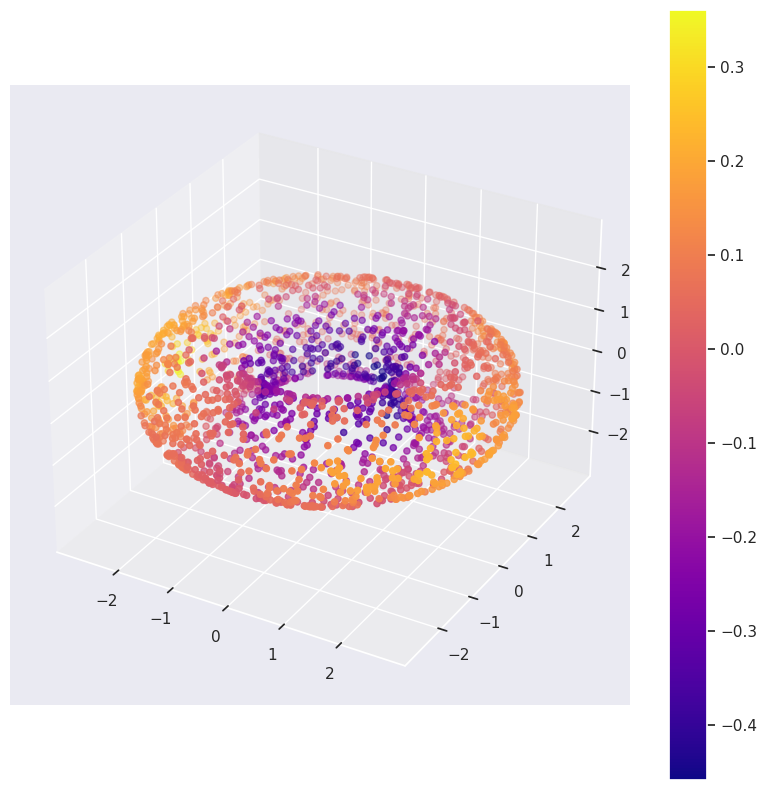

In [46]:
plot_3d(X_torus, ks_torus, colorbar = True)

In [47]:
!nbdev_export

In [ ]:
!nbdev_export